# Shortlisting And Ranking Franchise Applications Based on Location 

# 1. Importing Essential Libraries and Packages

In [1]:
!pip install bs4
!pip install requests
# !pip install beautifulsoup4
!pip install geopy
!conda install -c conda-forge folium=0.5.0 --yes
!pip install haversine

print("All Done")

     |████████████████████████████████| 122kB 15.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 122kB 28.7MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    entrypoints-0.3            |  pyhd8ed1ab_1003           8 KB  conda-forge
    folium-0.5.0               

In [2]:
import pandas as pd # for data processing
from pandas import json_normalize #converting json to DataFrame

import requests #for retreiving Information

import numpy as np # For sklearn clustering
import folium #for creating maps
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values


from sklearn.cluster import KMeans

import matplotlib.pyplot as plt 
from matplotlib import style
import matplotlib.cm as cm
import matplotlib.colors as colors

import haversine as hs # Calculate Distance
from haversine import Unit # Calculate distance in desired unit

# @hidden_cell
 # Hidden Crendential details

In [3]:
## @hidden_cell
# pamswati@gmail.com
CLIENT_ID = 'ETDTZK3JPZMFP0VZHRO2ZNGDWXTIBDODWP130BT5OLEKF2GE' # your Foursquare ID
CLIENT_SECRET = 'YGVVSZAV0C0P5IBH5C1HW2DKREMP3G1ANT0EYGJ1SGLWZYVQ' # your Foursquare Secret
ACCESS_TOKEN = 'OUFBG1UNC2OSFKMTLQVIZMO1DTPTS5V2ZMMFCPI1CM4PGPXK' # your FourSquare Access Token
VERSION = '20180604'
# search by  city category ID
city = 'Mumbai'



## 1. Explore in Given (Neighborhood_Location) And Create Applicants Database I used all cafes data as Applicant data

> `url = 'https://api.foursquare.com/v2/venues/`**explore**`?&client_id=`**CLIENT_ID**`&client_secret`**CLIENT_SECRET**`&v`**VERSION**`&ll`**LATITUDE**`,`**LONGITUDE**`&radius`**RADIUS**`&limit`= **LIMIT**'
`
## Here Let's assume all cafes are our applicants and create a dummy 


In [6]:

# search by  city category ID
# Café
category_id = '4bf58dd8d48988d16d941735'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, city, category_id ,50)
# Get json response
results = requests.get(url).json()
print(results['response'].keys())

dict_keys(['suggestedFilters', 'geocode', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'query', 'totalResults', 'suggestedBounds', 'groups'])


## Get relevant part of JSON and transform it into a _pandas_ dataframe


In [7]:
## Get relevant part of JSON and transform it into a _pandas_ dataframe
items = results['response']['groups'][0]['items']

df = json_normalize(items) # flatten JSON
applicant_df = pd.DataFrame(columns=['Applicant_ID','Latitude','Longitude'])

applicant_df['Applicant_ID'] = df['venue.id']
applicant_df['Latitude'] = df['venue.location.lat']
applicant_df['Longitude'] = df['venue.location.lng']
# applicant_df

In [8]:

# Pizza Place
category_id = '4bf58dd8d48988d1ca941735'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, city, category_id ,50)

# Get json response
results1 = requests.get(url).json()
#print(results1['response'].keys())
## Get relevant part of JSON and transform it into a _pandas_ dataframe
items1 = results1['response']['groups'][0]['items']

df2 = json_normalize(items1) # flatten JSON

## Get relevant part of JSON and transform it into a _pandas_ dataframe


In [9]:
pizza_df = pd.DataFrame(columns=['ID','Name','Address','Latitude','Longitude'])

pizza_df['ID'] = df2['venue.id']
pizza_df['Name'] = df2['venue.name']
pizza_df['Address'] = df2['venue.location.address']
pizza_df['Latitude'] = df2['venue.location.lat']
pizza_df['Longitude'] = df2['venue.location.lng']
# pizza_df

# Lets visualize all applicants and pizza places  On Map 

# Using KMeans clustering for the clsutering of the neighbourhoods¶


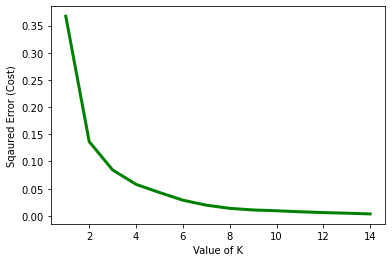

In [10]:

cost =[]
pizza_cluster = pizza_df.drop(['ID','Name','Address'],1)

for i in range(1, 15):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(pizza_cluster)
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 15), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

# the point of the elbow is the 
# most optimal value for choosing k

In [11]:
k= 4
kmeans = KMeans(n_clusters = k,random_state=0).fit(pizza_cluster)
kmeans.labels_
pizza_df.insert(0, 'Cluster Labels', kmeans.labels_)
# pizza_df

# Predicted clusters for All Applicants

In [12]:
# Create dataframe of all centers
cdf = pd.DataFrame(kmeans.cluster_centers_ , columns =['Latitude', 'Longitude'])
cdf['Name'] = cdf.index+1
cdf['Name'] = 'C' + cdf['Name'].apply(str)
cdf

,Latitude,Longitude,Name
0,19.118354,72.905375,C1
1,18.962861,72.820238,C2
2,19.152304,72.838936,C3
3,19.054661,72.845327,C4


# Determine cluster for applicants by using prediction.

In [13]:
# Select features and predict lables for each applicant
applicant_cluster = applicant_df.drop(['Applicant_ID'],1)

applicant_df.insert(0, 'Cluster Labels', kmeans.predict(applicant_cluster))
# applicant_df

In [15]:
#  Find distance of each applicant from each centroid
for lat1,lng1,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    loc1=(lat1,lng1)
    distance = []
    for lat2,lng2 in zip(applicant_df['Latitude'],applicant_df['Longitude']):
        loc2=(lat2,lng2)
        #To calculate distance in meters . By default the haversine function returns distance in km
        dist = hs.haversine(loc1,loc2,unit=Unit.METERS)
        # add distance to dataframe
        distance.append(dist)
    applicant_df[name+' distance'] = distance

# applicant_df

In [16]:
# Get the indicator variables and assign it to data frame "Cluster Labels":
dummy_variable_1 = pd.get_dummies(applicant_df["Cluster Labels"])


In [17]:
# Let's keep onle rank for the cluster they belongs to make other 0
for i in (cdf.index):
    n = str(i+1)
    # k= str(i)
    applicant_df['C'+ n +' Rank'] = applicant_df['C'+ n +' distance'].rank(ascending = 1).astype("int")*dummy_variable_1[i]
applicant_df['Total rank'] = 0
for i in (cdf.index):
    n= str(i+1)
    applicant_df['Total rank'] = applicant_df['Total rank'] + applicant_df['C'+ n +' Rank']
 
applicant_df

,Cluster Labels,Applicant_ID,Latitude,Longitude,C1 distance,C2 distance,C3 distance,C4 distance,C1 Rank,C2 Rank,C3 Rank,C4 Rank,Total rank
0,2,4b0587cdf964a52047a222e3,19.106153,72.825866,8463.153697,15944.410933,5312.213094,6079.951960,0,0,12,0,12
1,3,4be57f22bcef2d7fa4d603e5,19.062056,72.829506,10136.412448,11072.988020,10083.884023,1855.034039,0,0,0,4,4
2,3,4b0587cef964a52077a222e3,19.027721,72.855196,11374.267944,8094.706126,13957.913142,3170.077334,0,0,0,19,19
3,3,4d9b39ed2ae860fc0f5a81cb,19.067448,72.869006,6829.846798,12709.492878,9950.428009,2866.088344,0,0,0,16,16
4,3,4b0587cef964a5208aa222e3,19.061791,72.899479,6319.999268,13798.926142,11906.317706,5746.311912,0,0,0,24,24
5,0,4b507f47f964a520322527e3,19.116941,72.910082,518.823073,19563.238500,8445.224697,9708.780785,2,0,0,0,2
6,2,4e6cd1dc1495f34925b21012,19.104219,72.836759,7378.654279,15814.035187,5351.620733,5583.726115,0,0,13,0,13
7,3,4b0587e2f964a52094a522e3,19.055120,72.827006,10828.593931,10283.422467,10878.808901,1926.290926,0,0,0,8,8
8,2,515b06fee4b09b4ddd1b2407,19.136656,72.829136,8263.877540,19347.858649,2021.605392,9274.851888,0,0,3,0,3
9,3,5961c6615c68383973a43584,19.060480,72.824320,10675.121416,10863.243429,10325.205102,2300.711607,0,0,0,12,12


In [18]:
# Visualize Existing pizza places vs Applicants distribition over map
map_Mumbai = folium.Map(location=[19.07283,72.88261],zoom_start=12)

for lat,lng,name in zip(pizza_df['Latitude'],pizza_df['Longitude'],pizza_df['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=3,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_Mumbai)

for lat,lng,ID in zip(applicant_df['Latitude'],applicant_df['Longitude'],applicant_df['Applicant_ID']):
    l = '{}'.format(ID)
    label = folium.Popup(l, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=3,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_Mumbai)
map_Mumbai

In [19]:
# Visualize Cluster centers and area vs pizza places
# create map

map_clusters = folium.Map(location=[19.07283,72.88261],zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.Circle(
    [lat,lng],
    radius=5000,
    popup=label,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.3,
    parse_html=False).add_to(map_clusters)
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=3,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.9,
    parse_html=False).add_to(map_clusters)
for lat, lon, Name , cluster in zip(pizza_df['Latitude'], pizza_df['Longitude'], pizza_df['Name'], pizza_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

In [20]:
# create map

map_clusters1 = folium.Map(location=[19.07283,72.88261],zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.Circle(
    [lat,lng],
    radius=5000,
    popup=label,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.3,
    parse_html=False).add_to(map_clusters1)
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=3,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.9,
    parse_html=False).add_to(map_clusters1)

for lat, lon, cluster in zip(applicant_df['Latitude'], applicant_df['Longitude'], applicant_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
    

       
map_clusters1

# Applicants distribution arround center of each cluster above 

In [21]:
# create map

map_top3 = folium.Map(location=[19.07283,72.88261],zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.Circle(
    [lat,lng],
    radius=5000,
    popup=label,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.3,
    parse_html=False).add_to(map_top3)
for lat,lng,name in zip(cdf['Latitude'],cdf['Longitude'],cdf['Name']):
    l = '{}'.format(name)
    label = folium.Popup(l, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=3,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.9,
    parse_html=False).add_to(map_top3)

for lat, lon , cluster ,tr in zip(applicant_df['Latitude'], applicant_df['Longitude'], applicant_df['Cluster Labels'], applicant_df['Total rank']):
    if (tr<= 3):
        label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_top3)
    
map_top3

# Above Top 3 applicants in each cluster

In [22]:
# Visualize Cluster centers and area vs pizza places
# create map

map_newc = folium.Map(location=[19.07283,72.88261],zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

for lat, lon , cluster ,tr in zip(applicant_df['Latitude'], applicant_df['Longitude'], applicant_df['Cluster Labels'], applicant_df['Total rank']):
    if (tr<= 1):
        label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map_newc)
        label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
        folium.Circle(
            [lat,lon],
            radius=5000,
            popup=label,
            color='#3186cc',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3,
            parse_html=False).add_to(map_newc)
for lat, lon, Name , cluster in zip(pizza_df['Latitude'], pizza_df['Longitude'], pizza_df['Name'], pizza_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_newc)

map_newc

# Final four applicants location vs competitor pizza places